In [82]:
# here is how we activate an environment in our current directory
import Pkg; Pkg.activate(@__DIR__); Pkg.add("CircleFit"); Pkg.add("StatsBase");

# instantate this environment (download packages if you haven't)
Pkg.instantiate();

using Test, LinearAlgebra
import ForwardDiff as FD 
import FiniteDiff as FD2 
using CircleFit
using Plots
using StatsBase
import Convex as cvx
import ECOS

  Activating project at `~/Downloads/MSR Academics/OCRL_project`
   Resolving package versions...
    Updating `~/Downloads/MSR Academics/OCRL_project/Project.toml`
  [e2685f51] + ECOS v1.1.3
    Updating `~/Downloads/MSR Academics/OCRL_project/Manifest.toml`
  [fa961155] + CEnum v0.5.0
  [e2685f51] + ECOS v1.1.3
  [c2c64177] + ECOS_jll v200.0.800+0
Precompiling project...
  ✓ ECOS
  1 dependency successfully precompiled in 4 seconds. 220 already precompiled.
   Resolving package versions...
  No Changes to `~/Downloads/MSR Academics/OCRL_project/Project.toml`
  No Changes to `~/Downloads/MSR Academics/OCRL_project/Manifest.toml`


In [306]:
function dynamics(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ϕ = x[1:3]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B

    ϵ = 1e-6
    # R = (L/4)*((1/(tan(f_steerθ)+ϵ))+(1/(tan(r_steerθ)+ϵ)))
    V_l = (r/2)*(ω_fl+ω_rl)
    V_r = (r/2)*(ω_fr+ω_rr)
    R = (L/2)*(V_l+V_r)/(V_r-V_l+ϵ)
    f_steerθ = atan(L/(2*R+ϵ))
    r_steerθ = atan(L/(2*R+ϵ))

    Rfl = (L-B*sin(f_steerθ))/(2*sin(f_steerθ)+ϵ)
    Rfr = (L+B*sin(f_steerθ))/(2*sin(f_steerθ)+ϵ)
    Rrl = (L-B*sin(r_steerθ))/(2*sin(r_steerθ)+ϵ)
    Rrr = (L+B*sin(r_steerθ))/(2*sin(r_steerθ)+ϵ)
    v = ((R*r)/4)*((ω_fl/Rfl)+ (ω_fr/Rfr)+ (ω_rl/Rrl) + (ω_rr/Rrr))

    xdot = [v*cos(ϕ); v*sin(ϕ); v/(R+ϵ)]
    
    return xdot
end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

0.7251560203008716

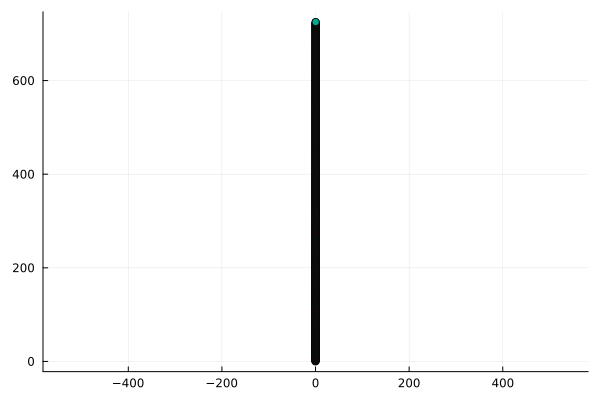

In [307]:
params = (r = 0.325, L = 1.91, B = 1.64)
u = [1.5, 1.5, 1.5, 1.5]

x0 = [0,0,pi/2]
nx = 3
N = 1001
dt = 1.0
t_vec = 0:dt:((N-1)*dt)

X = [zeros(nx) for i = 1:N]
X[1] = x0
for i = 1:(N-1)
    X[i+1] = rk4(params, X[i], u, dt)
end

X = hcat(X...)
x = X[1,:]
y = X[2,:]
print(y[2]-y[1])
# result = fit(Circle,x,y)
# @show coef(result)
# @show coefnames(result)
# @show rss(result)

display(scatter(X[1,:]', X[2,:]', legend=false, aspect_ratio=:equal))

In [242]:
### Traj Loading
function create_reference()
    # create reference trajectory for quadrotor 
    X_ref = [zeros(3) for i = 1:80]

    open("/Users/morganmayborne/Downloads/spline_test.txt") do f
        line = 1
        while !eof(f)
            x = readline(f)
            x, y = split(x, ',')
            X_ref[line] = [parse(Float64, x),parse(Float64, y), pi/4]
            line += 1
        end
    end
    U_ref = [zeros(4) for i = 1:(size(X_ref)[1]-1)]
    return X_ref, U_ref;
end

create_reference (generic function with 2 methods)

In [283]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm([ones(nx-1);1e-3*ones(1)])
    R = .001*diagm(ones(nu))
    Qf = 10*Q

    P = [zeros(nx,nx) for i = 1:N_mpc]
    K = [zeros(nu,nx) for i = 1:N_mpc-1]

    P[end] = deepcopy(Qf)
    
    for k = (N_mpc-1):-1:1
        K[k] = (R+B'*P[k+1]*B)\(B'*P[k+1]*A)
        P[k] = Q + A'*P[k+1]*(A-B*K[k])
    end
    
    # simulation 
    X_s = [zeros(nx) for i = 1:N_mpc]
    U_s = [zeros(nu) for i = 1:N_mpc-1]
    X_s[1] = xic
    @show X_s[1]
    @show X_ref_window[1]
    @show K[1]
    
    for i = 1:(N_mpc-1) 
        # TODO: put LQR control law here 
        # make sure to clamp 
        U_s[i] = clamp.(-K[i]*(X_s[i]-X_ref_window[i])+1e-6*ones(4), u_min, u_max)
        
        # simulate 1 step 
        X_sim[i+1] = A*X_s[i] + B*U_s[i]
    end
    @show U_s[1]
    println()
    return U_s[1]
end
        

# create our discrete time model 
dt = 0.5

X_ref, _ = create_reference()

# initial and goal states
x0 = deepcopy(X_ref[1])
xg = deepcopy(X_ref[80])

# bounds on U
u_max = 2*ones(4)
u_min = -u_max

# problem size and reference trajectory 
N = 80 
t_vec = 0:dt:((N-1)*dt)
params = (r = 0.325, L = 1.91, B = 1.64)

# MPC window size 
N_mpc = 20 
X_ref = vcat(X_ref, [xg for i = 1:(2*N_mpc)])

# sim size and setup 
N_sim = N + 20 
t_vec = 0:dt:((N_sim-1)*dt)
X_sim = [zeros(3) for i = 1:N_sim]
X_sim[1] = x0 
U_sim = [1e-6*ones(4) for i = 1:N_sim-1]

# simulate 
for i = 1:N_sim-1 
    # TODO: given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    A = FD.jacobian(_x -> rk4(params, _x, U_sim[i], dt), X_sim[i])
    B = FD.jacobian(_u -> rk4(params, X_sim[i], _u, dt), U_sim[i])
    
    nx, nu = size(B)
    discrete = exp([A B; zeros(nu,nx+nu)]*dt)
    A = discrete[1:nx,1:nx] # TODO 
    B = discrete[1:nx,(nx+1):end] # TODO 
    
    # TODO: call convex mpc controller with state estimate 
    u_mpc = convex_mpc(A, B, X_ref_tilde, X_sim[i],u_min, u_max, N_mpc)
    
    # commanded control goes into thruster model where it gets modified 
    U_sim[i] = deepcopy(u_mpc)
    
    # simulate one step 
    X_sim[i+1] = A*X_sim[i] + B*U_sim[i]
    
    X_sim[i+1][3] = rem(X_sim[i+1][3], 2π)
    if X_sim[i+1][3] < 0
        X_sim[i+1][3] += 2π
    end
end

print(X_sim[80])


X_s[1] = [0.0, 0.0, 0.785]
X_ref_window[1] = [0.0, 0.0, 0.785]
K[1] = [-87.16529045024973 101.12713372521023 23.463053714747033; 159.92757603720003 -128.15062830583037 -141.60495677231964; -87.16529045024971 101.12713372521024 23.463053714747062; 159.92757603719997 -128.15062830583037 -141.60495677231967]
U_s[1] = [1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6]

X_s[1] = [5.663022845236817e-9, 1.7384051772583907e-7, 1.2942462097706253]
X_ref_window[1] = [0.07931185303980172, 0.08601837002478495, 0.785]
K[1] = [-125.40651062813151 45.800583934859915 23.46305371477993; 202.1106217849991 -33.922111941573064 -141.60495677231955; -125.40651062813146 45.800583934859894 23.463053714779907; 202.1106217849991 -33.92211194157307 -141.60495677231953]
U_s[1] = [-2.0, 2.0, -2.0, 2.0]

X_s[1] = [-0.13135072967018968, -0.46278877126496737, 3.40470892841012]
X_ref_window[1] = [0.20790202653448023, 0.2103076250182242, 0.785]
K[1] = [25.148701090736708 -131.11837750830603 23.4630537147758; -74.75340096671646 190.81756